# <font color=blue size="10">Analyze changes in tuning curves under inactivations of PV</font>

We use the functional derived from a difference of gaussians (Mexican hat) to fit the bandwidth tuning curves

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import tqdm
from importlib import reload
#from tuning_curve_fit_funcs import carandini_fit_wStats
import tuning_curve_fit_funcs as tcfits
import tuning_curve_feature_plotting as tcfplot
reload(tcfits)
reload(tcfplot)

<module 'tuning_curve_feature_plotting' from '/Users/yashar/Google-Drive/Documents/Work/Projects/AuditoryContextualModul/Matlab/tuning_curve_feature_plotting.py'>

In [2]:
DATA_DIR = '/Users/yashar/Google-Drive/Documents/Work/Projects/AuditoryContextualModul/Matlab/Lakunina-Jaramillo-Data/'
filename = 'inactivated_cells_responses.npz'
data = np.load(DATA_DIR + filename)
print("\n".join(data.keys())) #:gives the list of arrays in the file
data.close()

SOMBaselineSpikeRates
laser
noSOMsustainedResponses
PVBaselineSpikeRates
bandwidths
noPVsustainedResponses


In [3]:
BLisZeroBW = True #whether to replace pure tone evoked rates with baseline (spontaneous) rates
WNoctave = 6 #what BW (in octaves) to attribute to white noise stimulus

# PV inactivation

In [8]:
#fit all cell TC's with and without PV inactivations 
Celltype = 'PV'
CelltypeLabel = 'PV-inactivation'
Response_type = 'sustained'
mExp = 1

TCfeatures_PV_Laser_on = tcfits.FitAllCells(DATA_DIR + filename, Celltype, Response_type, BLisZeroBW,\
                             WNoctave,  mFixed=mExp, function_class_fit= "diff_of_gauss_fit",\
                                INACTIVATION=True,laser=1)

TCfeatures_PV_Laser_off = tcfits.FitAllCells(DATA_DIR + filename, Celltype, Response_type, BLisZeroBW,\
                             WNoctave,  mFixed=mExp, function_class_fit= "diff_of_gauss_fit",\
                                INACTIVATION=True,laser=0)

 35%|███▌      | 6/17 [00:00<00:01,  8.11it/s]/Users/yashar/Google-Drive/Documents/Work/Projects/AuditoryContextualModul/Matlab/tuning_curve_fit_funcs.py:221: RuntimeWarning: divide by zero encountered in double_scalars
  Stats['SuppInd'] = 1 - Stats['wnResp']/Stats['maxResp']
/Users/yashar/Google-Drive/Documents/Work/Projects/AuditoryContextualModul/Matlab/tuning_curve_fit_funcs.py:230: RuntimeWarning: divide by zero encountered in double_scalars
  RawStats['SuppInd'] = 1 - RawStats['wnResp']/RawStats['maxResp']
 12%|█▏        | 2/17 [00:00<00:00, 15.45it/s]


 Elapsed time was 1.7517 seconds


100%|██████████| 17/17 [00:01<00:00, 11.96it/s]


 Elapsed time was 1.4233 seconds


### Goodness of fit

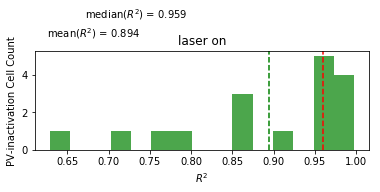

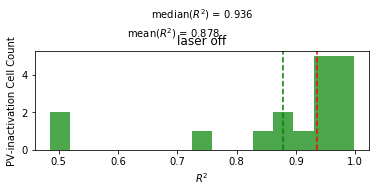

In [9]:
%matplotlib inline

for ii,laser in enumerate(['on','off']):
    TCfeatures = eval('TCfeatures_'+Celltype+'_Laser_'+laser)
    R2 = TCfeatures['GoF']['R2']
    R2Label = TCfeatures['GoFLabels']['R2']
    plt.subplot(2,1,ii+1)
    #fig = plt.figure(figsize=(10,5))
    n, bins, patches = plt.hist(R2, 15, facecolor='g',alpha=0.7)
    plt.axvline(x=np.median(R2),c='r',linestyle='--')
    plt.axvline(x=np.mean(R2),c='g',linestyle='--')
    plt.xlabel(R2Label)
    plt.ylabel(CelltypeLabel+ ' Cell Count')
    plt.title('laser '+laser)
    plt.text(np.median(R2)*.7, 7, 'median('+R2Label+') = %1.3f' % np.median(R2))
    plt.text(np.mean(R2)*.7, 6, 'mean('+R2Label+') = %1.3f' % np.mean(R2))
    #plt.axis([40, 160, 0, 0.03])
    #plt.grid(True)
    plt.show()

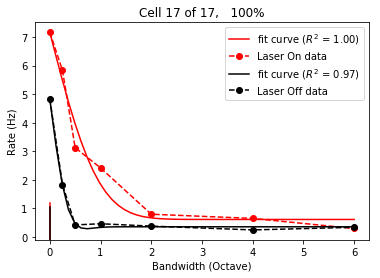

In [10]:
TCfeaturesOn = eval('TCfeatures_'+Celltype+'_Laser_on')
TCfeaturesOff = eval('TCfeatures_'+Celltype+'_Laser_off')
test_BWs = TCfeaturesOn['test_BWs']
Bandwidths = TCfeaturesOn['Bandwidths']
R2off = TCfeaturesOff['GoF']['R2']
R2on = TCfeaturesOn['GoF']['R2']    
    
#visualize all fits, from worse to best
import pylab as pl
from IPython import display

R2inds = np.argsort(R2off)
ii=0
for cel in R2inds[:]:
    pl.clf()
    baselineOff = TCfeaturesOff['Baselines'][cel]
    baselineOn = TCfeaturesOn['Baselines'][cel]
    pl.plot(test_BWs,baselineOn + TCfeaturesOn['fitTCs'][:,cel],'r-',label='fit curve ('+R2Label+' = %1.2f)' % R2off[cel])
    pl.plot(Bandwidths, baselineOn + TCfeaturesOn['rawTCs'][:,cel],'ro--',label='Laser On data')
    pl.axvline(TCfeaturesOn['MiscParams']['prefBW'][cel],ymax=.17,c='r')
#    pl.axhline(x=baselineOn,c='k',linestyle='--')
    pl.plot(test_BWs,baselineOff + TCfeaturesOff['fitTCs'][:,cel],'k-',label='fit curve ('+R2Label+' = %1.2f)' % R2on[cel])
    pl.plot(Bandwidths, baselineOff + TCfeaturesOff['rawTCs'][:,cel],'ko--',label='Laser Off data')
    pl.axvline(TCfeaturesOff['MiscParams']['prefBW'][cel],ymax=.15,c='k')
#    pl.axhline(x=baselineOff,c='k',linestyle='--')

    pl.xlabel('Bandwidth (Octave)')
    pl.ylabel('Rate (Hz)')
    ii+=1
    pl.title('Cell %i of %i,   %i%%' % (ii,len(R2),100 * ii//len(R2)))
    pl.legend()
    display.display(pl.gcf())
    display.clear_output(wait=True)
    time.sleep(.25)

In [11]:
#Save all fit plots, from worse to best
PLOTS_DIR = DATA_DIR + 'Plots/TCplots/inactivate'+Celltype+'/'
%matplotlib inline

R2off = TCfeaturesOff['GoF']['R2']
R2on = TCfeaturesOn['GoF']['R2']    
R2inds = np.argsort(R2off)
ii = 1
for cel in R2inds[:]:
    fig, ax = plt.subplots()

    baselineOff = TCfeaturesOff['Baselines'][cel]
    baselineOn = TCfeaturesOn['Baselines'][cel]
    ax.plot(test_BWs,baselineOn + TCfeaturesOn['fitTCs'][:,cel],'r-',label='fit curve ('+R2Label+' = %1.2f)' % R2on[cel])
    ax.plot(Bandwidths, baselineOn + TCfeaturesOn['rawTCs'][:,cel],'ro--',label='Laser On data')
    ax.axvline(TCfeaturesOn['MiscParams']['prefBW'][cel],ymax=.17,c='r')
#    ax.axhline(x=baselineOn,c='k',linestyle='--')
    ax.plot(test_BWs,baselineOff + TCfeaturesOff['fitTCs'][:,cel],'k-',label='fit curve ('+R2Label+' = %1.2f)' % R2off[cel])
    ax.plot(Bandwidths, baselineOff + TCfeaturesOff['rawTCs'][:,cel],'ko--',label='Laser Off data')
    ax.axvline(TCfeaturesOff['MiscParams']['prefBW'][cel],ymax=.15,c='k')
#    ax.axhline(x=baselineOff,c='k',linestyle='--')

    TCfeatures = TCfeaturesOff
    pars = [TCfeatures['MiscParams']['SuppInd_wBL'][cel],TCfeatures['CarandiniParams']['RD'][cel], TCfeatures['CarandiniParams']['RS'][cel],TCfeatures['CarandiniParams']['sigmaD'][cel],TCfeatures['CarandiniParams']['sigmaS'][cel]]
    TCfeatures = TCfeaturesOn
    pars = pars + [TCfeatures['MiscParams']['SuppInd_wBL'][cel],TCfeatures['CarandiniParams']['RD'][cel], TCfeatures['CarandiniParams']['RS'][cel],TCfeatures['CarandiniParams']['sigmaD'][cel],TCfeatures['CarandiniParams']['sigmaS'][cel]]
    ax.set_title(('OFF: $SI$ = %2.1f, $R_D$ = %2.1f, $R_S$ = %2.1f, $\sigma_D$ = %2.1f, $\sigma_S$ = %2.1f\n'+\
                 'ON: $SI$ = %2.1f, $R_D$ = %2.1f, $R_S$ = %2.1f, $\sigma_D$ = %2.1f, $\sigma_S$ = %2.1f') % tuple(pars))
    ax.set_xlabel('Bandwidth (Octave)')
    ax.set_ylabel('Rate (Hz)')
    ax.legend()

    fig.savefig(PLOTS_DIR +CelltypeLabel+'_cell_TC_gauss_fit_'+str(ii)+'.png')
    plt.close(fig)
    ii +=1

In [88]:
SAVE_DIR = '/Users/yashar/Google-Drive/Documents/Work/Projects/AuditoryContextualModul/Matlab/'
from scipy.io import savemat, loadmat, whosmat
filename = SAVE_DIR+'TCfeaturesToPlotOn.mat'
savemat(filename,TCfeaturesOn, oned_as='column')

MYDIC = loadmat(filename)
print(MYDIC.keys())


dict_keys(['Ncells', 'MiscParamsNames', 'MiscParams', '__version__', 'MiscParamsLabels', 'RawMiscParams', 'CarandiniParamsLabels', 'fitTCs', 'BLisZeroBW', 'GoFNames', '__globals__', 'rawTCs', 'Bandwidths', 'Fit_curve_type', 'GoF', 'Celltype', 'test_BWs', 'Response_type', 'CarandiniParams', 'GoFLabels', '__header__', 'CarandiniParamsNames', 'Baselines'])


In [93]:
plt.isinteractive()

True

In [89]:
SAVE_DIR = '/Users/yashar/Google-Drive/Documents/Work/Projects/AuditoryContextualModul/Matlab/'
import deepdish as dd
filename = SAVE_DIR+'TCfeaturesToPlotOn.h5'
dd.io.save(filename,TCfeaturesOn)

MYDIC = dd.io.load(filename)
print(MYDIC.keys())


ImportError: No module named 'deepdish'

## Tuning curve feature distributions

In [7]:
TCfeaturesToPlotOn = TCfeaturesOn['MiscParams']
TCfeaturesToPlotOff = TCfeaturesOff['MiscParams']
TCparamNames = TCfeaturesOff['MiscParamsNames']
ParamsLabels = TCfeaturesOff['MiscParamsLabels']
print(" , ".join(TCparamNames))

AbsPrefBW , Baseline , SuppInd_noBL , SuppInd_wBL , peakAbsResp , peakNegResp , peakRate , peakResp , peakSignedResp , prefBW , wnRate , wnResp


Ncells = 57


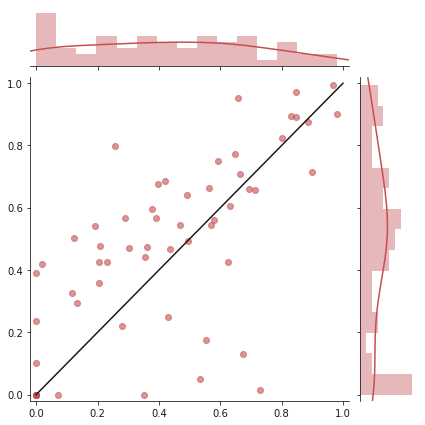

In [90]:
import seaborn as sns
sns.set(style="white", color_codes=True,palette='husl')
sns.set_palette("husl")
sns.reset_orig()
print('Ncells = {}'.format(TCfeaturesOn['Ncells']))

xs = TCfeaturesToPlotOff['SuppInd_wBL']
ys = TCfeaturesToPlotOn['SuppInd_wBL']
marg_dict = {'kde':True,'bins':15}
ee = .02
lims = [-ee,1+ee]
jgrd = sns.JointGrid(x=xs, y=ys, xlim=lims, ylim=lims)
jgrd.plot_joint(plt.scatter, color="r",alpha=.6)#, edgecolor="white")
jgrd.plot_marginals(sns.distplot, kde=True, color="r",bins = 15)
# jgrd = sns.jointplot(x=xs,y=ys, kind='scatter', color='r', xlim=lims, ylim=lims, marginal_kws=marg_dict,alpha = .6)
fig = jgrd.fig
axs = fig.get_axes()
axs[0].plot([0,1],[0,1],'k-');
#fig.get_children()

In [ ]:
%matplotlib inline

import tuning_curve_feature_plotting as tcfplot
reload(tcfplot)

betterOrder = [10,1,4,3,2,7,5,9,11,12,8,6]
tcfplot.makeHistograms(TCfeaturesToPlotOff, TCparamNames,ParamsLabels, CelltypeLabel,betterOrder,nbins=15)
print("Ncells = %1.0f" % TCfeatures['Ncells'])

In [ ]:
betterOrder = [10,1,4,3,2,7,5,9,11,12,8,6]
tcfplot.makeHistograms(TCfeatures['RawMiscParams'], TCparamNames,ParamsLabels, CelltypeLabel,betterOrder,nbins=15)
print("Ncells = %1.0f" % TCfeatures['Ncells'])

In [ ]:
n_ftr = 12
pairs = list(zip(range(n_ftr),range(n_ftr)))
betterOrder = [10,1,4,3,2,7,5,9,11,12,8,6]
pairs = [[betterOrder[i]-1 for i in p] for p in pairs] 
tcfplot.makeScatterPlots(TCfeaturesToPlot, TCparamNames, ParamsLabels,\
                         pairs,figsize=(15,15),cols=4,hspace = .3, wspace = .4,\
                        yTCfeatures = TCfeatures['RawMiscParams'])
print("\n\n Comparing raw (y-axis) vs. fit-curve-extracted TC features")

#### Correlations of preferred BW with other quantities:

In [ ]:
pairs = [(5,1),(6,1),(8,1),(9,1),(10,1),(3,1),(11,1)]
pairs = [[betterOrder[i-1]-1 for i in p] for p in pairs] 
tcfplot.makeScatterPlots(TCfeaturesToPlot, TCparamNames, ParamsLabels, pairs,uniformYs=True,figsize=(15,10))

#### Correlations of *Suppression Index* with other quantities:

In [ ]:
pairs = [(5,3),(6,3),(8,3),(9,3),(10,3),(1,3),(11,3)]
pairs = [[betterOrder[i-1]-1 for i in p] for p in pairs] 
tcfplot.makeScatterPlots(TCfeaturesToPlot, TCparamNames, ParamsLabels, pairs,uniformYs=True,figsize=(15,10))

#### Correlations of rates and responses (not interesting)

In [ ]:
inds = range(5,13) #for rates
pairs = [(j,i) for i in inds for j in inds]
pairs = [[betterOrder[i-1]-1 for i in p] for p in pairs] 
tcfplot.makeScatterPlots(TCfeaturesToPlot, TCparamNames, ParamsLabels, \
                 pairs,cols=len(inds),figsize=(27/1.5,23/1.5),hspace=.4,wspace=.4,uniformYs=True,symm=True)

## Difference of Gaussians parameters

In [ ]:
TCfeatures = eval(Celltype+'features')

TCfeaturesToPlot = TCfeatures['CarandiniParams']
TCparamNames = TCfeatures['CarandiniParamsNames']
ParamsLabels = TCfeatures['CarandiniParamsLabels']
print(" , ".join(TCparamNames))

In [ ]:
%matplotlib inline

betterOrder = [1,4,2,3,5,6] #list(range(1,7))
tcfplot.makeHistograms(TCfeaturesToPlot, TCparamNames,ParamsLabels, CelltypeLabel,betterOrder,figsize=(8,10),nbins=15)
print("Ncells = %1.0f" % TCfeatures['Ncells'])

Mean sigma_D is smaller for PV than E and SOM (in general), which may be consistent with 
another paper's (can't remember which) finding (told to me by Santiago) about the RF width of
the three cell types. 


On the other hand, mean sigma_S of PV and SOM is larger than E's, in line with their weaker surround suppression

In [ ]:
inds = range(6)
pairs = [(j,i) for i in inds for j in inds]
betterOrder = [1,2,3,5,6,4]
pairs = [[betterOrder[i]-1 for i in p] for p in pairs] 
tcfplot.makeScatterPlots(TCfeaturesToPlot, TCparamNames, ParamsLabels, \
                 pairs,cols=len(inds),figsize=(14,14),hspace=.4,wspace=.4,symm=True)

In [ ]:
betterOrder_x = [2,3,5,6]
betterOrder_y = [10,1,4,8,6,12]
pairs = [[i-1, j-1] for j in betterOrder_y for i in betterOrder_x ] 
sig_vec = tcfplot.makeScatterPlots(TCfeaturesToPlot, TCparamNames, ParamsLabels, \
                 pairs,cols=len(betterOrder_x),figsize=(14,18),hspace=.3,wspace=.2,uniformYs=True,uniformXs=True,\
                 yTCfeatures = TCfeatures['MiscParams'],yTCparamsNames = TCfeatures['MiscParamsNames'],\
                         yTCparamsLabels = TCfeatures['MiscParamsLabels'])

In [ ]:
pairs1 = [pairs[i] for i in np.nonzero(sig_vec)[0]]
sigs = tcfplot.makeScatterPlots(TCfeaturesToPlot, TCparamNames, ParamsLabels, \
                 pairs1,cols=len(betterOrder_x),figsize=(14,6),wspace=.5,\
                 yTCfeatures = TCfeatures['MiscParams'],yTCparamsNames = TCfeatures['MiscParamsNames'],\
                         yTCparamsLabels = TCfeatures['MiscParamsLabels'])

# Limiting to positively responsive cells

In [ ]:
%matplotlib inline
cellinds = np.nonzero(TCfeatures['RawMiscParams']['peakResp']>0)[0] #== np.nonzero(TCfeatures['RawMiscParams']['prefBW']>0)[0])
n1 = len(cellinds)
Ncells = TCfeatures['Ncells']
perc = 100*n1//Ncells
#print(('\n\n %i%% (or %i/%i)   of ' % (perc,len(cellinds),TCfeatures['Ncells']))+CelltypeLabel+' cells have a positive response.')
print(('\n\n %i/%i  of ' % (len(cellinds),TCfeatures['Ncells']))+CelltypeLabel+' cells have a positive response.')
colors  = ['lightcoral', 'lightskyblue']
labels = ['positive response','suppression only']
plt.pie([n1,Ncells-n1], colors=colors, startangle=90,labels=labels, autopct='%1.0f%%');
#plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.show()

In [ ]:
TCfeatures = eval(Celltype+'features')
TCfeaturesToPlot = TCfeatures['MiscParams']
TCparamNames = TCfeatures['MiscParamsNames']
ParamsLabels = TCfeatures['MiscParamsLabels']

%matplotlib inline
betterOrder = [10,4,2,7,5,9,11,12]
tcfplot.makeHistograms(TCfeaturesToPlot, TCparamNames,ParamsLabels, CelltypeLabel,betterOrder,nbins=15,cell_inds=cellinds)
print("Ncells = %1.0f" % n1)

In [ ]:
TCfeatures = eval(Celltype+'features')

TCfeaturesToPlot = TCfeatures['CarandiniParams']
TCparamNames = TCfeatures['CarandiniParamsNames']
ParamsLabels = TCfeatures['CarandiniParamsLabels']

%matplotlib inline

betterOrder = [2,3,5,6] #list(range(1,7))
tcfplot.makeHistograms(TCfeaturesToPlot, TCparamNames,ParamsLabels, CelltypeLabel,betterOrder,figsize=(8,10),nbins=15,cell_inds=cellinds)
print("Ncells = %1.0f" % n1)

<style type="text/css">
body  {
   background-color:#E8E2E8;
};
</style>
<font color=#dd8010 size="4">
Summary: It didn't really make a difference

# Limiting to SI>0 cells

In [ ]:
%matplotlib inline
cellinds = np.nonzero(TCfeatures['MiscParams']['SuppInd_wBL']>0)[0] #== np.nonzero(TCfeatures['RawMiscParams']['prefBW']>0)[0])
n1 = len(cellinds)
Ncells = TCfeatures['Ncells']
perc = 100*n1//Ncells
#print(('\n\n %i%% (or %i/%i)   of ' % (perc,len(cellinds),TCfeatures['Ncells']))+CelltypeLabel+' cells have a positive response.')
print(('\n\n %i/%i  of ' % (len(cellinds),TCfeatures['Ncells']))+CelltypeLabel+' cells have a suppression index > 0.')
colors  = ['lightcoral', 'lightskyblue']
labels = ['SI > 0','SI = 0']
plt.pie([n1,Ncells-n1], colors=colors, startangle=90,labels=labels, autopct='%1.0f%%');
#plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.show()

In [ ]:
TCfeatures = eval(Celltype+'features')
TCfeaturesToPlot = TCfeatures['MiscParams']
TCparamNames = TCfeatures['MiscParamsNames']
ParamsLabels = TCfeatures['MiscParamsLabels']

%matplotlib inline
betterOrder = [10,4,2,7,5,9,11,12]
tcfplot.makeHistograms(TCfeaturesToPlot, TCparamNames,ParamsLabels, CelltypeLabel,betterOrder,nbins=15,cell_inds=cellinds)
print("Ncells = %1.0f" % n1)

In [ ]:
TCfeatures = eval(Celltype+'features')

TCfeaturesToPlot = TCfeatures['CarandiniParams']
TCparamNames = TCfeatures['CarandiniParamsNames']
ParamsLabels = TCfeatures['CarandiniParamsLabels']

%matplotlib inline

betterOrder = [2,3,5,6] #list(range(1,7))
tcfplot.makeHistograms(TCfeaturesToPlot, TCparamNames,ParamsLabels, CelltypeLabel,betterOrder,figsize=(8,10),nbins=15,cell_inds=cellinds)
print("Ncells = %1.0f" % n1)